In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

collocation_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
from interpolation import BarycentricInterpolation

### Data Generation

In [2]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

data.loc[:,'hour'] = pd.to_datetime(data['settlement_date']).dt.hour

# select the main columns for the intial testing
data_subsample = data[['temperature', 'hour', 'nd']][:400]

t = jnp.linspace(0., 1., data_subsample.shape[0])

def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

# interpolate the whole dataset
cs_temp = CubicSpline(t, data_subsample['temperature'])
cs_hour = CubicSpline(t, data_subsample['hour'])
cs_nd = CubicSpline(t, data_subsample['nd'])

#-------------------------------------TRAIN-TEST SPLIT-------------------------------------#
split, end = 50, 100

t_train = t[:split]
t_test = t[split:end]

#-------------------------------------CHEBYSHEV NODES--------------------------------------#
train_end = t_train.shape[0]*3
x_train_cheb = generate_chebyshev_nodes(train_end, 0, t_train.max())

y_train_temp = cs_temp(x_train_cheb)
y_train_hour = cs_hour(x_train_cheb)
y_train_nd = cs_nd(x_train_cheb)

#----------------------------------COMBINE INTO TRAIN--------------------------------------#
X_train = np.vstack([y_train_temp, y_train_hour]).T
# X_train = y_train_temp.T
X_train = pd.DataFrame(X_train, columns=['temperature', 'hour'])
y_train = pd.DataFrame(y_train_nd)

data_test = data_subsample[split:end]

#----------------------------------LOCATE TEST SET---------------------------------------#
X_test = data_test[['temperature', 'hour']]
y_test = data_test['nd']

#---------------------------------------SCALE--------------------------------------------#
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

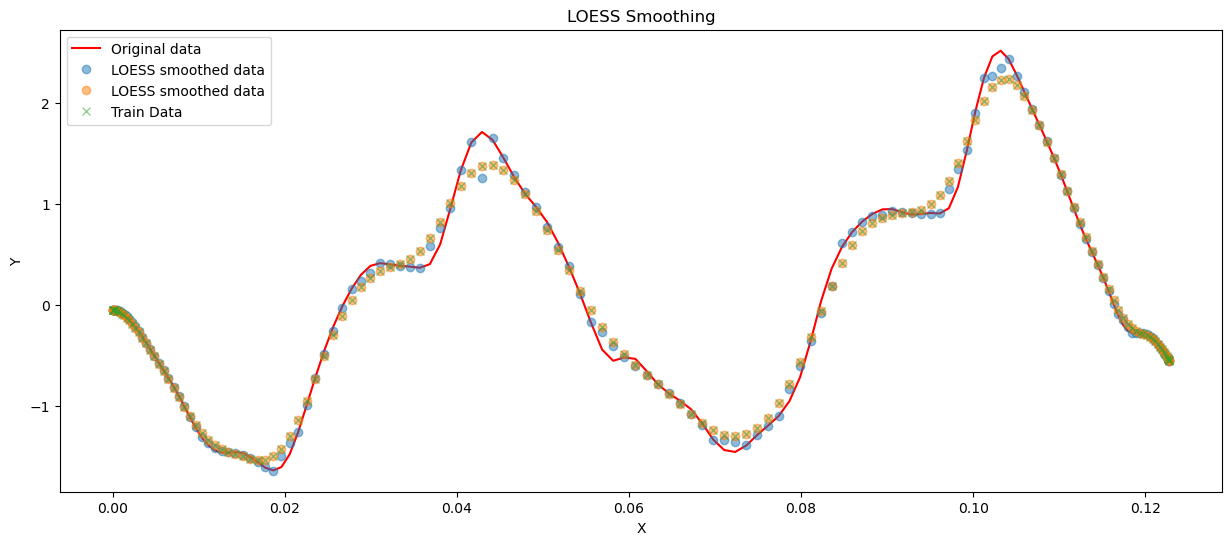

In [3]:
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

lowess = sm.nonparametric.lowess
y_smoothed = lowess(np.squeeze(y_train_scaled), x_train_cheb, frac=0.05)  # `frac` is the fraction of data used for each local model
y_new = y_smoothed[:, 1]
x_new = y_smoothed[:, 0]

y_new_gaussian = gaussian_filter1d(y_new, sigma=2)
cs_y_new = CubicSpline(x_new, y_new_gaussian)
y_train_cheb = cs_y_new(x_train_cheb)

plt.figure(figsize=(15, 6))
plt.plot(x_train_cheb, y_train_scaled, 'r-', label='Original data')
plt.plot(x_new, y_new, 'o', label='LOESS smoothed data', alpha=0.5)
plt.plot(x_new, y_new_gaussian, 'o', label='LOESS smoothed data', alpha=0.5)
plt.plot(x_train_cheb, y_train_cheb, 'x', label='Train Data', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LOESS Smoothing')
plt.show()


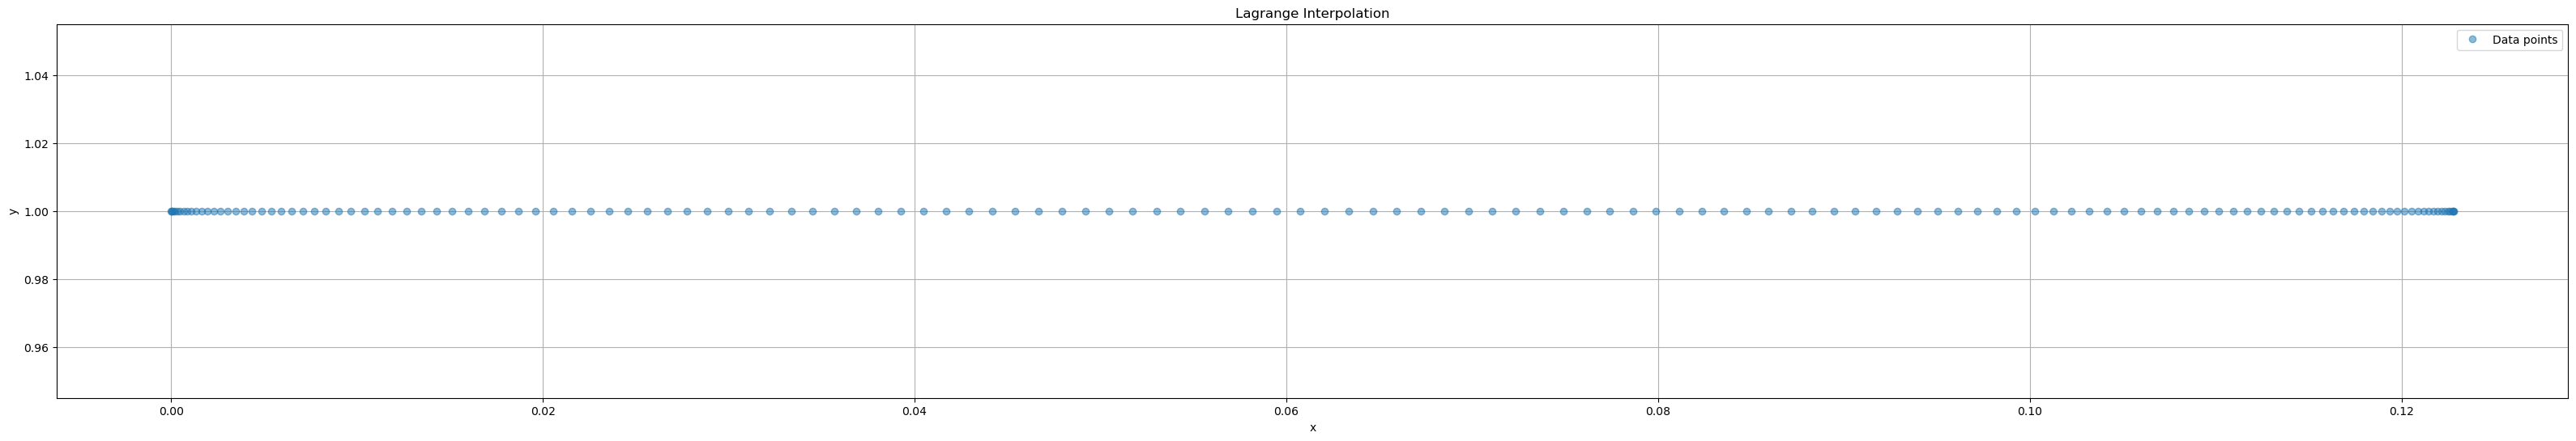

In [4]:
ones = np.ones_like(x_train_cheb)

plt.figure(figsize=(40, 6))
plt.plot(x_train_cheb, ones, 'o', label='Data points', alpha = 0.5)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange Interpolation')
plt.grid(True)
plt.show()

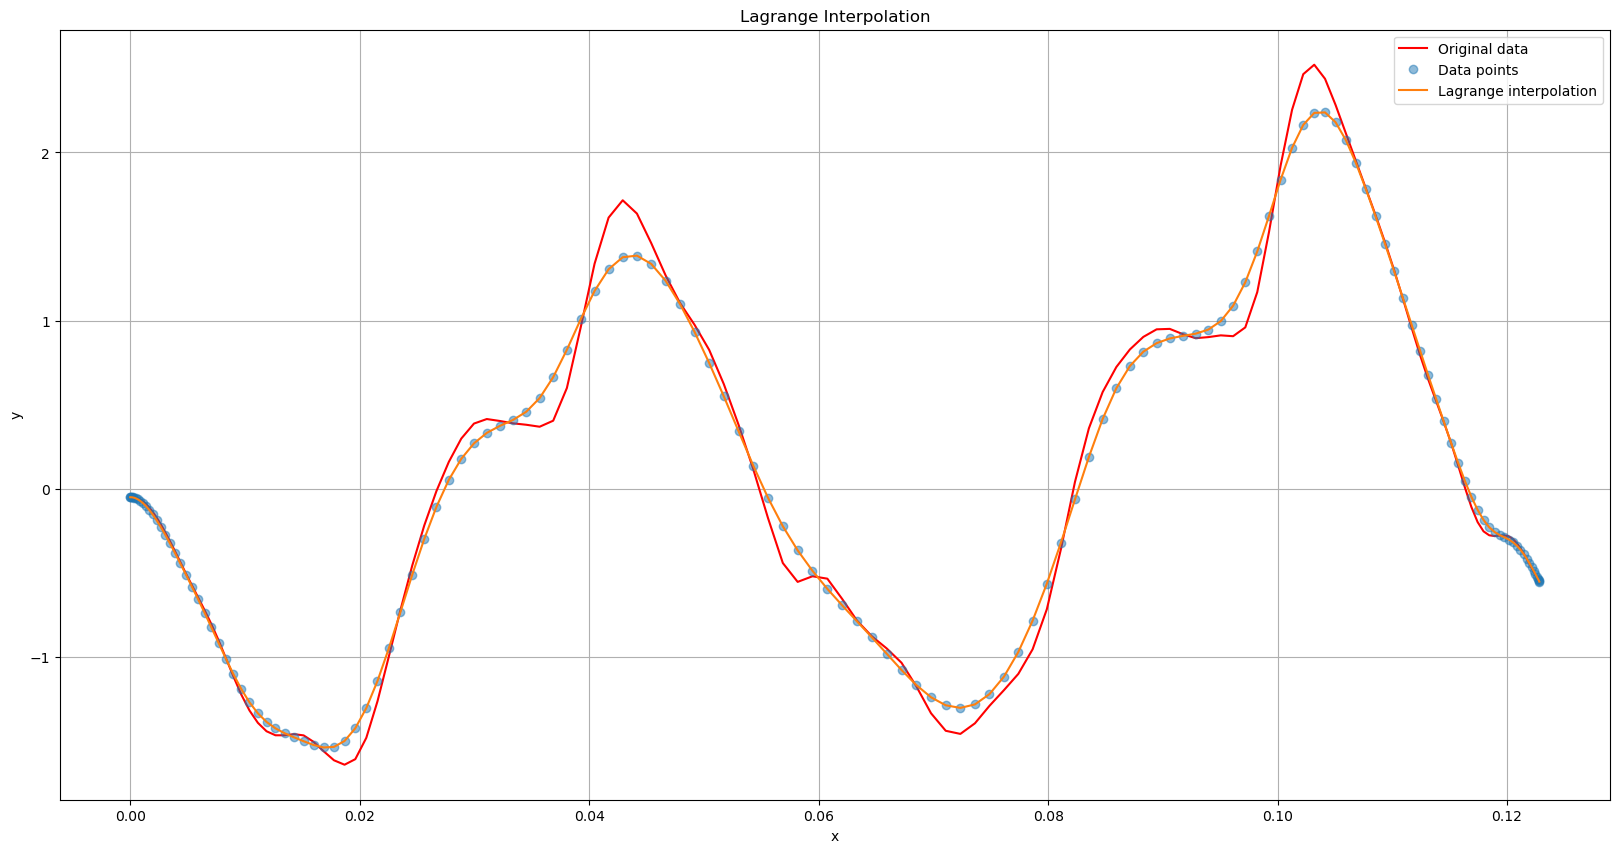

In [5]:
interpolator1 = BarycentricInterpolation(len(x_train_cheb), np.min(x_train_cheb), np.max(x_train_cheb))
# collocation_nodes = interpolator1.nodes

interpolator1.fit(y_train_cheb)
y_interpolated = interpolator1.evaluate(x_train_cheb)

plt.figure(figsize=(20, 10))
plt.plot(x_train_cheb, y_train_scaled, 'r-', label='Original data')
plt.plot(x_train_cheb, y_train_cheb, 'o', label='Data points', alpha = 0.5)
plt.plot(x_train_cheb[:], y_interpolated[:],label='Lagrange interpolation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange Interpolation')
plt.grid(True)
plt.show()

### Data Check

In [6]:
weights = compute_weights(x_train_cheb)
D = np.array(lagrange_derivative(x_train_cheb, weights))

`initial model version`

In [7]:
y = y_train_cheb

ys = np.array(y)
ys = np.atleast_2d(ys).T

ts = np.array(x_train_cheb)
Ds = np.array(D)

extra_input = np.array(X_train_scaled)

(150, 1)


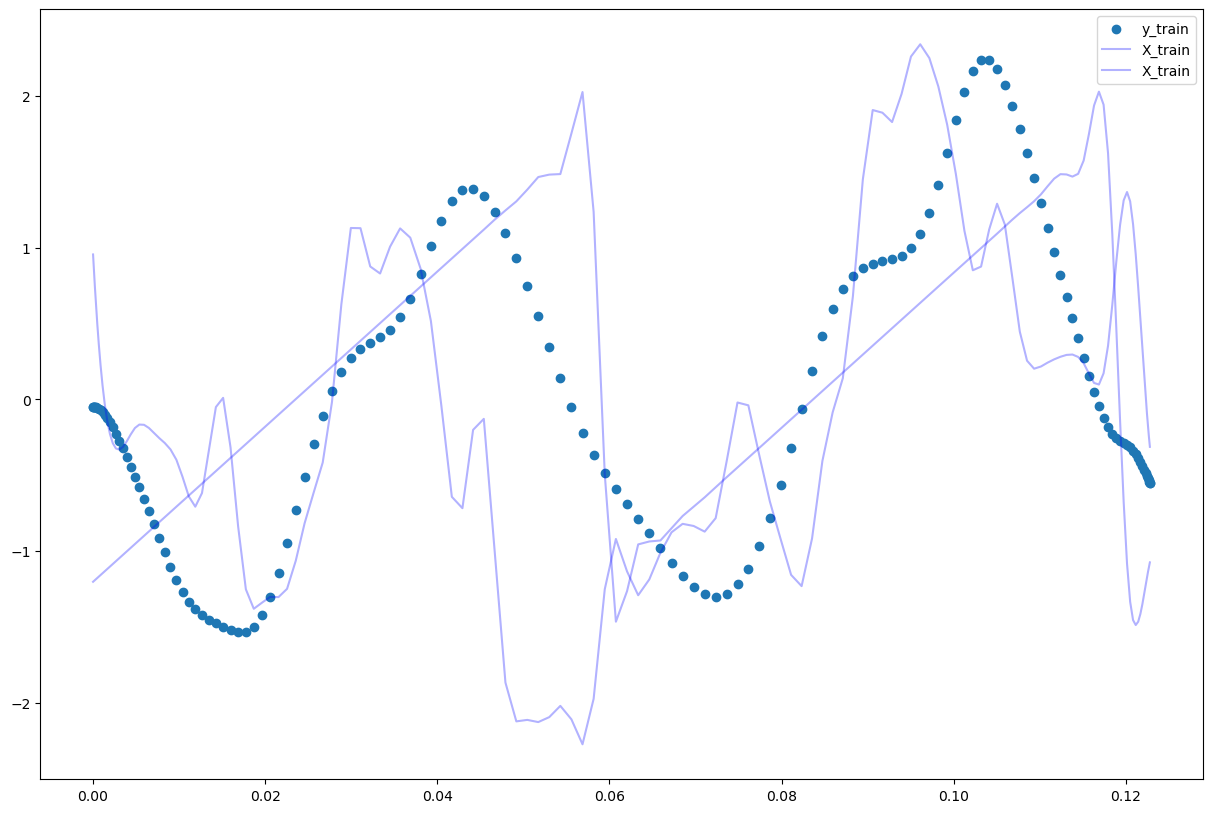

In [8]:
print(ys.shape)
plt.figure(figsize=(15, 10))
#plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
#plt.scatter(ts, estimated_solution, label='y_train')
plt.scatter(ts, ys, label='y_train')
plt.plot(ts, extra_input, 'b-', label='X_train', alpha = 0.3)

#plt.plot(t_test, X_test_scaled, label='X_test', alpha = 0.5)
#plt.plot(t_test, y_test_scaled, label='y_test', ls = '--')

plt.legend()
plt.show()

In [9]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

# ----------------------------------------------------------- #
#import neural_net_pyomo

#importlib.reload(neural_net_pyomo)
#NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [3, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          # "acceptable_tol": 1e-15,
          # "acceptable_constr_viol_tol": 1e-15,
          # "acceptable_dual_inf_tol": 1e-15,
          # "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.00001, 
                           penalty_lambda_input = 0.0,
                           # constraint_penalty = 1e-5,  
                           time_invariant=True,
                           extra_input = extra_input, # X
                           w_init_method = 'random', 
                           params = params
                           # constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    37650
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    15451

Total number of variables............................:      251
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      25

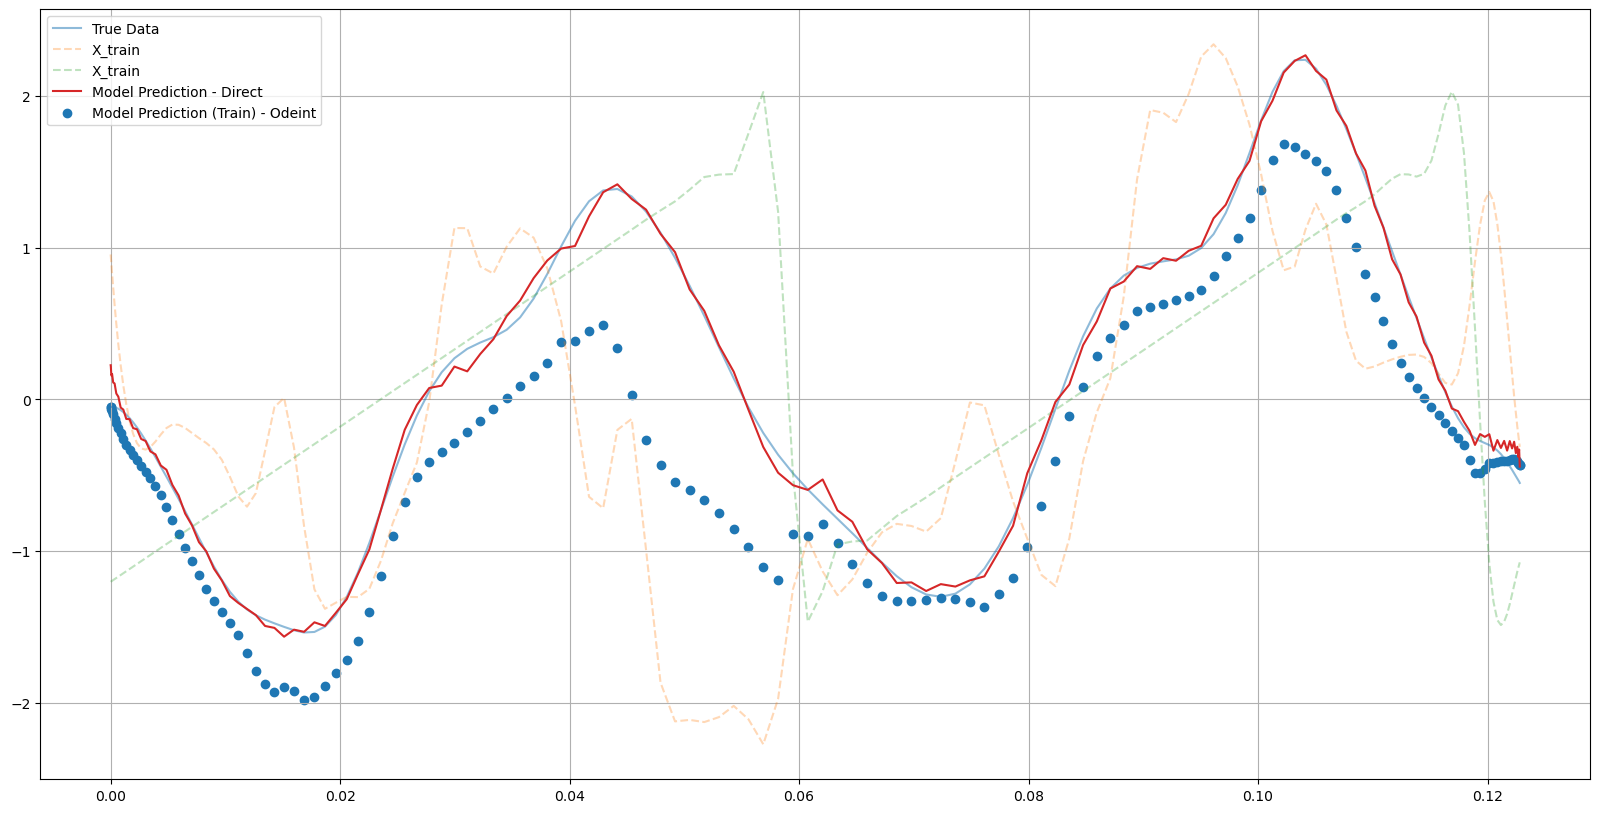

In [10]:
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (extra_input, ts))

y1 = y_pred[-1]

# test
y_init_test = y_pred[-1]
extra_args = np.array(X_test_scaled)

plt.figure(figsize=(20, 10))
#plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, label='True Data', alpha = 0.5)
#plt.plot(t_test, y_test_scaled, 'r', alpha = 0.5)
plt.plot(ts, extra_input, label='X_train', alpha = 0.3, ls = '--')
#plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.plot(ts, u_model, label='Model Prediction - Direct')
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
#plt.scatter(t_test, y_pred_test, label='Model Prediction (Train) - Odeint')
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

---

(150, 4)


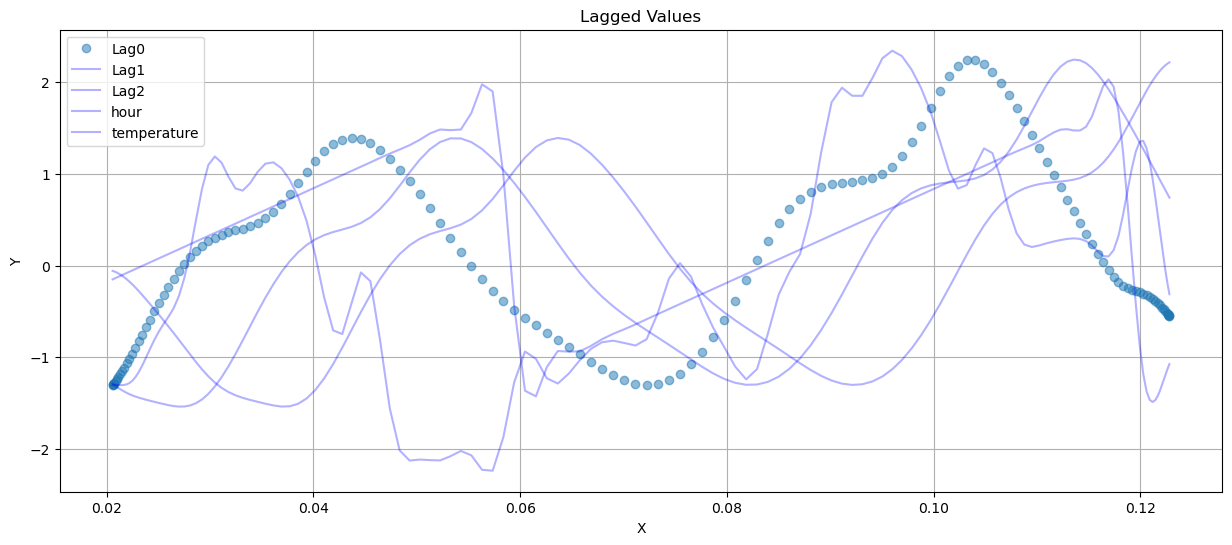

In [72]:
x_train_cheb_lag1 = x_train_cheb + 0.01
x_train_cheb_lag2 = x_train_cheb + 0.02

map = x_train_cheb < x_train_cheb_lag2[0]
OFFSET = len(x_train_cheb_lag1[map])

x_new = x_train_cheb[OFFSET:]
x_train_cheb_lags = generate_chebyshev_nodes(train_end, x_new.min(), x_new.max())

cs_lag0 = CubicSpline(x_train_cheb, y_train_cheb)
y_train_cheb_lag0 = cs_lag0(x_train_cheb_lags)

cs_lag1 = CubicSpline(x_train_cheb_lag1, y_train_cheb)
y_train_cheb_lag1 = cs_lag1(x_train_cheb_lags)

cs_lag2 = CubicSpline(x_train_cheb_lag2, y_train_cheb)
y_train_cheb_lag2 = cs_lag2(x_train_cheb_lags)

# TEMPERATURE
x_train_temp = np.array(X_train_scaled['temperature'])
cs_temp = CubicSpline(x_train_cheb, x_train_temp)
x_train_temp = cs_temp(x_train_cheb_lags)

# HOUR
x_train_hour = np.array(X_train_scaled['hour'])
cs_hour = CubicSpline(x_train_cheb, x_train_hour)
x_train_hour = cs_hour(x_train_cheb_lags)

Xs = np.vstack([y_train_cheb_lag1, y_train_cheb_lag2, x_train_hour, x_train_temp]).T
#Xs = np.vstack([y_train_cheb_lag2 - y_train_cheb_lag1, x_train_hour, x_train_temp]).T
#Xs = np.vstack([y_train_cheb_lag1, y_train_cheb_lag2]).T

print(Xs.shape)
plt.figure(figsize=(15, 6))
plt.plot(x_train_cheb_lags, y_train_cheb_lag0, 'o', label='Lag0', alpha=0.5)
plt.plot(x_train_cheb_lags, y_train_cheb_lag1, 'b-', label='Lag1', alpha=0.3)
plt.plot(x_train_cheb_lags, y_train_cheb_lag2, 'b-', label='Lag2', alpha=0.3)
plt.plot(x_train_cheb_lags, x_train_hour, 'b-', label='hour', alpha=0.3)
plt.plot(x_train_cheb_lags, x_train_temp, 'b-', label='temperature', alpha=0.3)

#plt.plot(x_train_cheb_lags, y_train_cheb_lag2 - y_train_cheb_lag1, 'b-', label='temperature', alpha=1)
# plt.plot(x_train_cheb_lag2[first_pos_index], y_train_cheb[first_pos_index], 'o', label='First Positive Value of the Offset', alpha=0.7)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lagged Values')
plt.grid(True)
plt.show()

In [73]:
# CURRENT

weights = compute_weights(x_train_cheb_lags)
D = np.array(lagrange_derivative(x_train_cheb_lags, weights))

ys = np.array(y_train_cheb_lag0)
ys = np.atleast_2d(ys).T

ts = np.array(x_train_cheb_lags)
Ds = np.array(D)

extra_input = Xs

(150, 4)


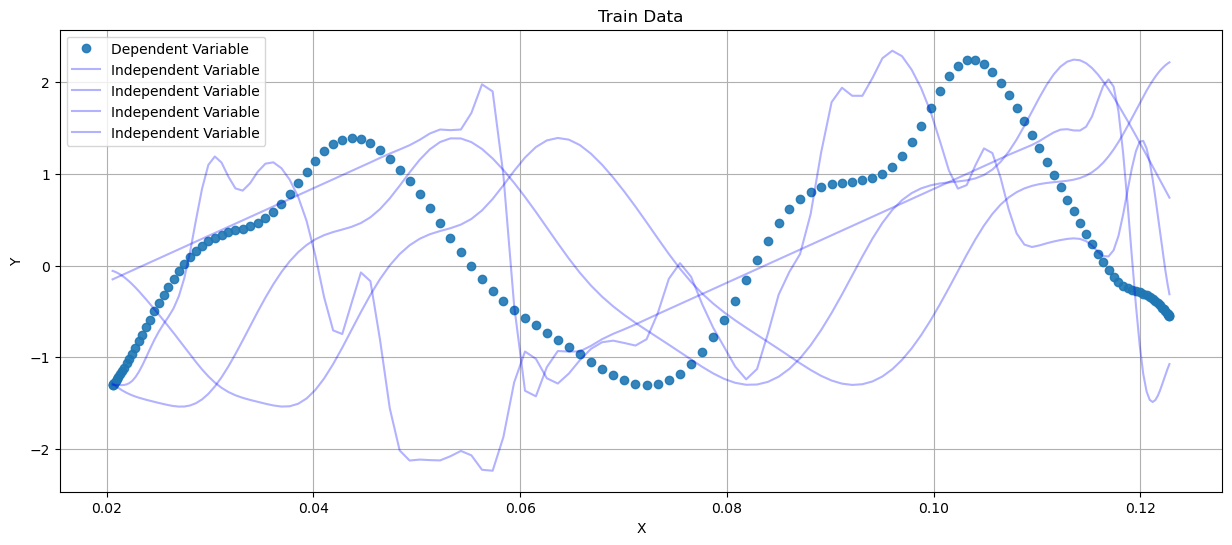

In [99]:
print(Xs.shape)
plt.figure(figsize=(15, 6))
plt.plot(ts, ys, 'o', label='Dependent Variable', alpha=0.9)
plt.plot(ts, extra_input, 'b-', label='Independent Variable', alpha=0.3)
# plt.plot(x_train_cheb_lag2[first_pos_index], y_train_cheb[first_pos_index], 'o', label='First Positive Value of the Offset', alpha=0.7)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Train Data')
plt.grid(True)
plt.show()

In [111]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

# ----------------------------------------------------------- #
#import neural_net_pyomo

#importlib.reload(neural_net_pyomo)
#NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [5, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-10
params = {"tol":1e-10, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          # "acceptable_tol": 1e-15,
          # "acceptable_constr_viol_tol": 1e-15,
          # "acceptable_dual_inf_tol": 1e-15,
          # "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 1000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Ds),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = ys, 
                           penalty_lambda_reg = 0.001, 
                           penalty_lambda_input = 0.0000,
                           # constraint_penalty = 1e-5,  
                           time_invariant = True,
                           extra_input = extra_input, # X
                           w_init_method = 'xavier', 
                           params = params
                           # constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    43359
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    21571

Total number of variables............................:      291
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      29

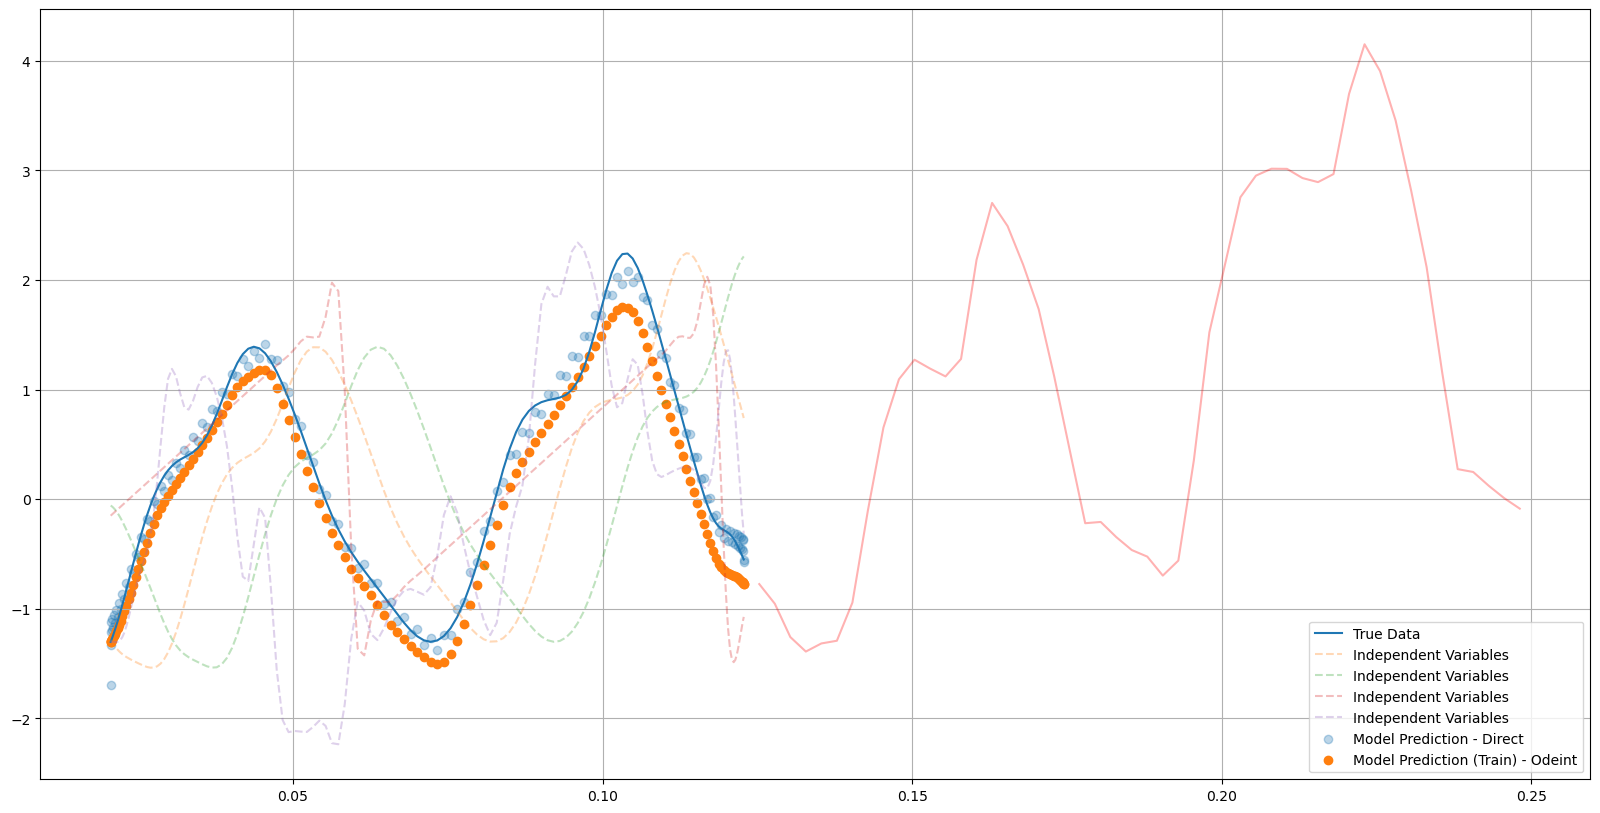

In [119]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

y0 = ys[0]
step_1 = 150
y_pred1 = ode_model.neural_ode(y0, ts[:step_1], (extra_input[:step_1], ts[:step_1]))
y_init_test = y_pred[-1]
extra_args = np.array(X_test_scaled)

plt.figure(figsize=(20, 10))
#plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(t_test, y_test_scaled, 'r', alpha = 0.3)
plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
# plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

plt.scatter(ts, u_model, label='Model Prediction - Direct', alpha = 0.3)
plt.scatter(ts[:step_1], y_pred1, label='Model Prediction (Train) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.1269378662109375, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


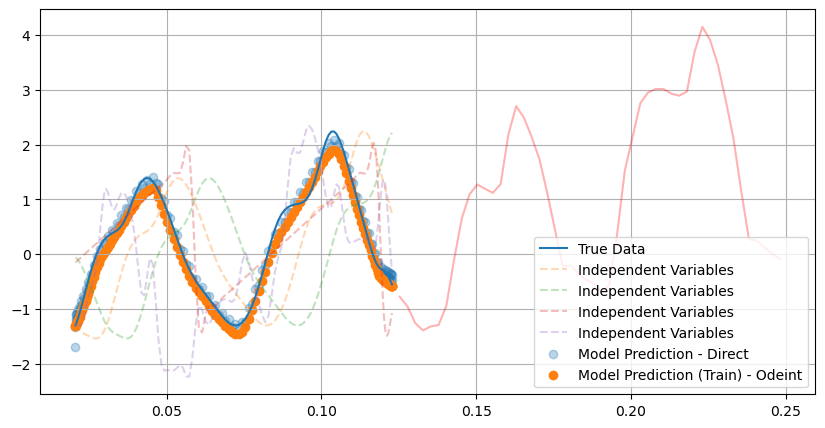

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2041878700256348, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


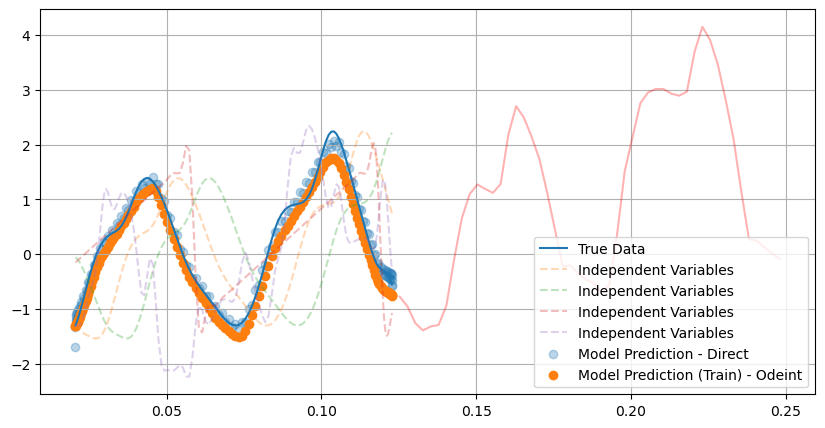

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2701187133789062, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


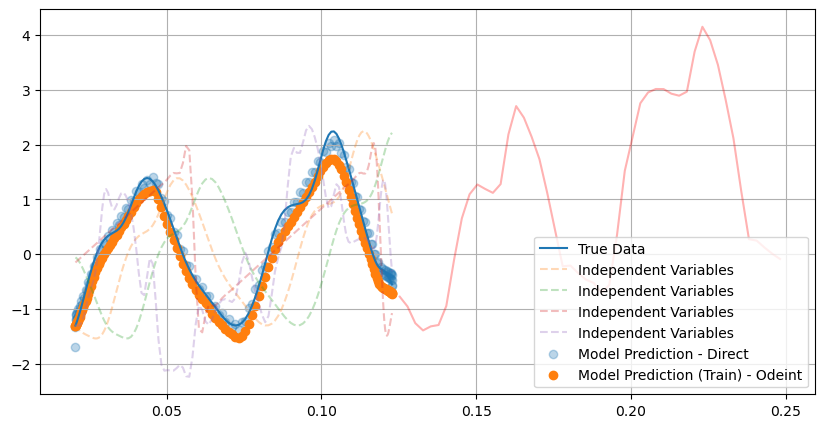

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.0889689922332764, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


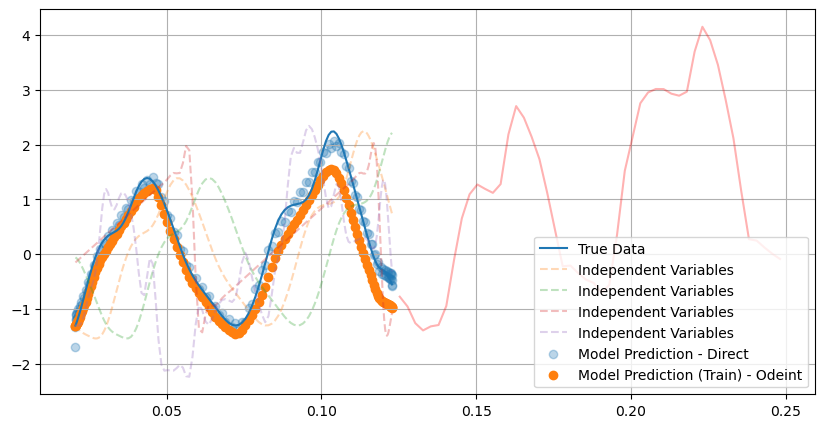

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.8203229904174805, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


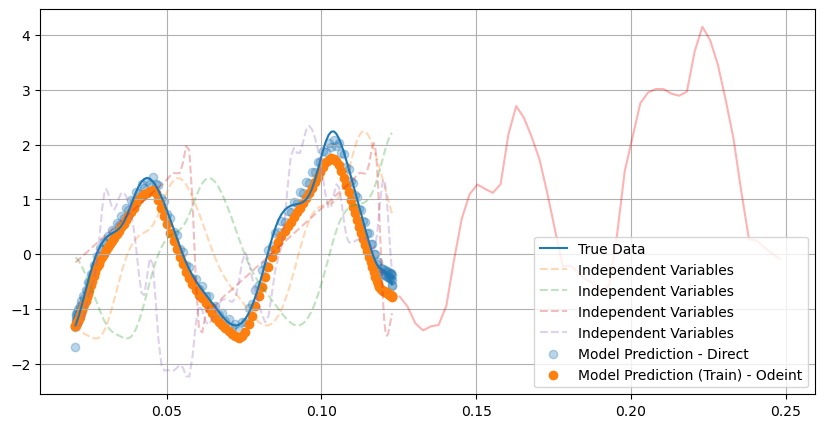

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.5227360725402832, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


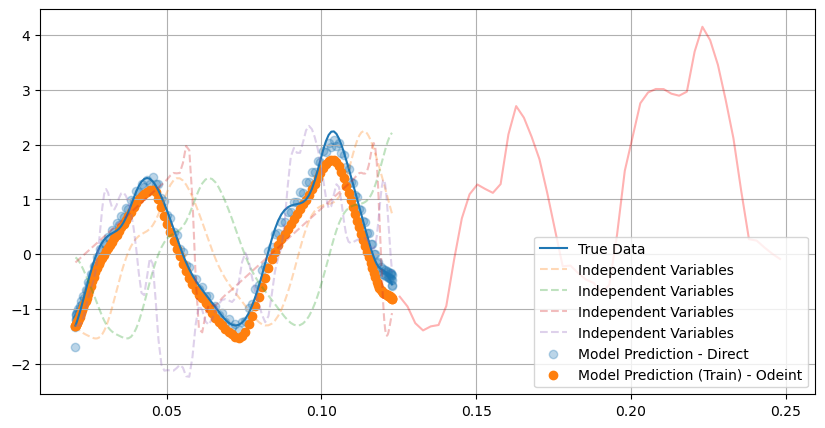

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.75142502784729, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


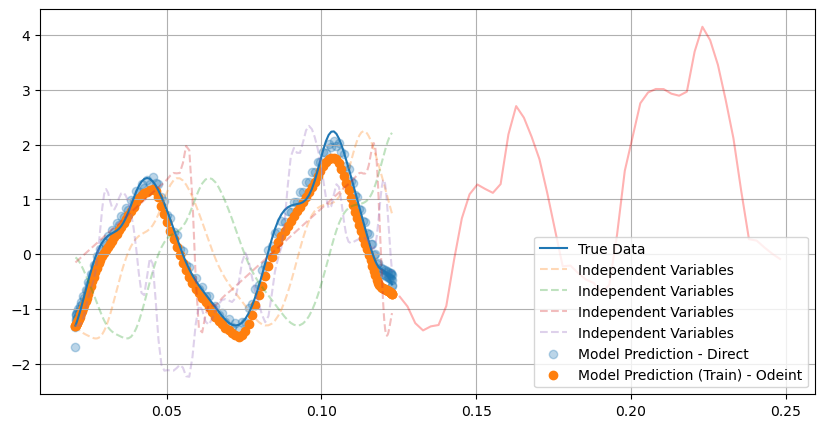

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.9750750064849854, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


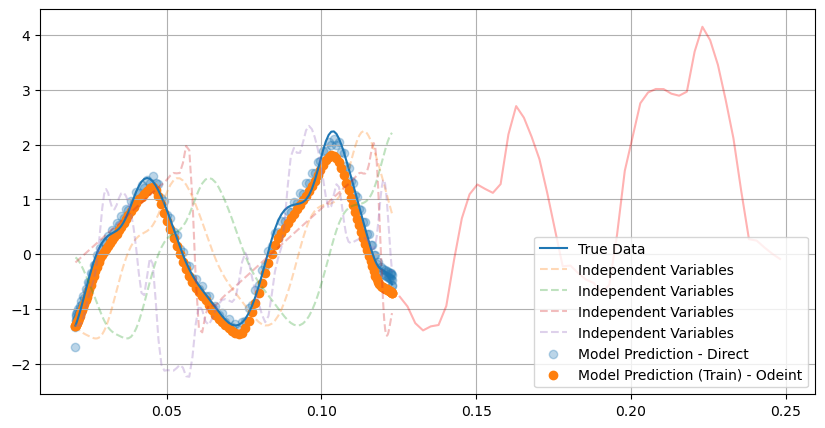

y
Ipopt 3.14.16: tol=1e-10
dual_inf_tol=1e-10
compl_inf_tol=1e-10
constr_viol_tol=1e-10
acceptable_iter=0
halt_on_ampl_error=yes
print_level=2
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.677610158920288, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


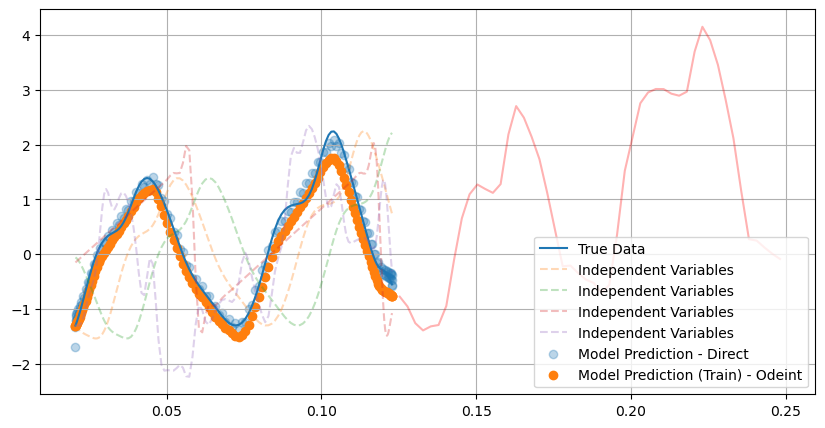

In [118]:
for i in range(1, 10):
        layer_widths = [5, 30, 1]

        # solver.options['print_level'] = 5
        tol = 1e-10
        params = {"tol":1e-10, 
                "dual_inf_tol": tol, 
                "compl_inf_tol": tol,
                "constr_viol_tol": tol, 
                
                # repeat the same for the acceptable tolerances
                # "acceptable_tol": 1e-15,
                # "acceptable_constr_viol_tol": 1e-15,
                # "acceptable_dual_inf_tol": 1e-15,
                # "acceptable_compl_inf_tol": 1e-15,
                "acceptable_iter": 0, 
                
                "halt_on_ampl_error" : 'yes',
                "print_level": 2, 
                #"hessian_approximation": 'limited-memory', 
                #"mu_strategy": 'adaptive', 
                #"check_derivatives_for_naninf": 'yes',
                "max_iter": 1000}

        start_timer_build = time.time()
        ode_model = NeuralODEPyomo(np.array(ys), # y
                                np.array(ts), # t
                                np.array(Ds),
                                
                                layer_widths, act_func = "tanh", 
                                y_init = ys, 
                                penalty_lambda_reg = 0.001, 
                                penalty_lambda_input = 0.0000,
                                # constraint_penalty = 1e-5,  
                                time_invariant = True,
                                extra_input = extra_input, # X
                                w_init_method = 'xavier', 
                                params = params
                                # constraint="l1"
                                )

        ode_model.build_model()
        end_timer_build = time.time()

        result = ode_model.solve_model()
        u_model = ode_model.extract_solution().T

        y0 = ys[0]
        step_1 = 149
        step_2 = 150
        y_pred1 = ode_model.neural_ode(y0, ts[:step_1], (extra_input[:step_1], ts[:step_1]))
        y1 = ys[step_1]
        y_pred2 = ode_model.neural_ode(y1, ts[step_1:step_2], (extra_input[step_1:step_2], ts[step_1:step_2]))

        # test
        y_init_test = y_pred[-1]
        extra_args = np.array(X_test_scaled)

        plt.figure(figsize=(10, 5))
        #plt.plot(ts, y_train_scaled[offset : train_end], label='True Data', alpha = 0.5)
        plt.plot(ts, ys, label='True Data', alpha = 1)
        plt.plot(t_test, y_test_scaled, 'r', alpha = 0.3)
        plt.plot(ts, extra_input, label='Independent Variables', alpha = 0.3, ls = '--')
        # plt.plot(t_test, np.array(X_test_scaled), alpha = 0.3, ls = '--')

        plt.scatter(ts, u_model, label='Model Prediction - Direct', alpha = 0.3)
        plt.scatter(ts[:step_1], y_pred1, label='Model Prediction (Train) - Odeint')
        plt.scatter(ts[step_1:step_2], y_pred2)
        #plt.scatter(t_test, y_pred_test, label='Model Prediction (Train) - Odeint')
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.show()

---

----

In [15]:
from data_generation import generate_ode_data

#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t_vdp)
D_vdp = np.array(lagrange_derivative(t_vdp, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [29]:
import neural_net_pyomo_2

importlib.reload(neural_net_pyomo_2)
NeuralODEPyomo = neural_net_pyomo_2.NeuralODEPyomo

layer_widths = [2, 10, 2]

# solver.options['print_level'] = 5
tol = 1e-5
params = {"tol":1e-7, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          #"acceptable_tol": 1e-15,
          #"acceptable_dual_inf_tol": 1e-15,
          #"acceptable_constr_viol_tol": 1e-15,
          #"acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          "max_iter": 3000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_vdp), # y
                           np.array(t_vdp), # t
                           np.array(D_vdp),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(estimated_solution_vdp), 
                           penalty_lambda_reg = 0.001, 
                           penalty_lambda_input = 0.00,
                           # constraint_penalty = 1e-5,  
                           
                           # extra_input = extra_input, # X
                           w_init_method = 'xavier', 
                           params = params,
                           constraint="l1"
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution()

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/03_eda_energy_consumtion/neural_net_pyomo_2.py:74: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20641

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      452


In [30]:
from jax.experimental.ode import odeint
 
y0 = jnp.array([0.0, 1.0])
y_pred_train = ode_model.neural_ode(y0, t_vdp)  
mae_train = jnp.mean(jnp.abs(y_pred_train - y_vdp))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = ode_model.neural_ode(y1, t_test_vdp[N-1:]) 
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_vdp[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.11943044941570297
Test MAE: 0.49445077743189725


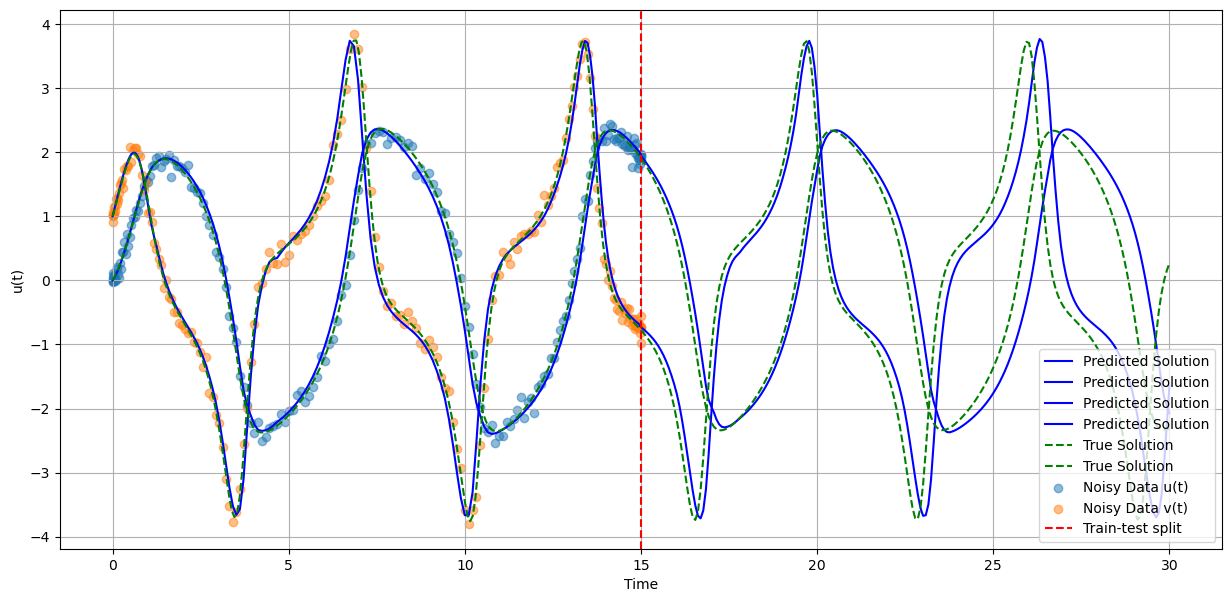

In [31]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
# plt.plot(t_vdp, np.array(u_model).T, 'b', label='Predicted Solution')
plt.plot(t_vdp, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_vdp[N-1:], y_pred_test, 'b', label='Predicted Solution')

plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [164]:
t_new = x_train_cheb[offset : split]
t_new.shape
X_train_scaled[offset : split].shape

(97, 2)

In [167]:
X_train_scaled[offset : split]

,temperature,hour
3,0.959727,-1.277286
4,0.791652,-1.253379
5,0.642722,-1.222682
6,0.544745,-1.185226
7,0.516285,-1.141050
...,...,...
95,-1.732811,-0.970897
96,-1.751552,-0.938147
97,-1.763682,-0.914371
98,-1.769392,-0.900562


In [ ]:
def neural_ode(self, params, y0, t, state, extra_args=None): 
    results = []    
       
    def func(y, t, args):
        input = jnp.atleast_1d(y)
        
        if not self.time_invariant:
            input = jnp.append(input, t)
            
        if args is not None:
            extra_inputs, t_all = args
            
            if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                # after confirming that extra inputs is an array
                # there are 2 further options to consider:
                # multiple datapoints and multiple features
                
                if extra_inputs.ndim == 2:
                    # we have multiple datapoints
                    index = jnp.argmin(jnp.abs(t_all - t))
                    for extra_input in extra_inputs[index]:
                            input = jnp.append(input, extra_input)
                            
                elif extra_inputs.ndim == 1:
                    # we have a single datapoint so no need to slice the index
                    for extra_input in extra_inputs:
                            input = jnp.append(input, extra_input)
                    
            else: # if a single value, simply append it
                input = jnp.append(input, extra_inputs)
        
        result = state.apply_fn({'params': params}, input) 
             
        return result
        
    return odeint(func, y0, t, extra_args)

In [166]:
def func(y, t, args):
    input = jnp.atleast_1d(y)
    
    if not self.time_invariant:
        input = jnp.append(input, t)
        
    if args is not None:
        extra_inputs, t_all = args
        
        if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
            # after confirming that extra inputs is an array
            # there are 2 further options to consider:
            # multiple datapoints and multiple features
            
            if extra_inputs.ndim == 2:
                # we have multiple datapoints
                index = jnp.argmin(jnp.abs(t_all - t))
                for extra_input in extra_inputs[index]:
                        input = jnp.append(input, extra_input)
                        
            elif extra_inputs.ndim == 1:
                # we have a single datapoint so no need to slice the index
                for extra_input in extra_inputs:
                        input = jnp.append(input, extra_input)
                
        else: # if a single value, simply append it
            input = jnp.append(input, extra_inputs)
    
    result = state.apply_fn({'params': params}, input) 
            
    return result
    
def system_dynamics(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    current_index = np.searchsorted(t_new, t, side='right') - 1
    
    input = np.array([y[0]])
    
    # for each embedding:
    for i in range(m):
        input = np.append(input, embeddings[current_index][i])
        
    # input = np.array([y[0]])
    du_dt = ode_model.predict(input) 
    return du_dt

initial_conditions = np.array(y_train_scaled[offset])
t_span = (t_new[0], t_new[-1])
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(X_train_scaled[offset : split], t_new))

y_pred_train = sol.y
t_points = sol.t

ode_solution = np.squeeze(y_pred_train.T)

KeyError: 0

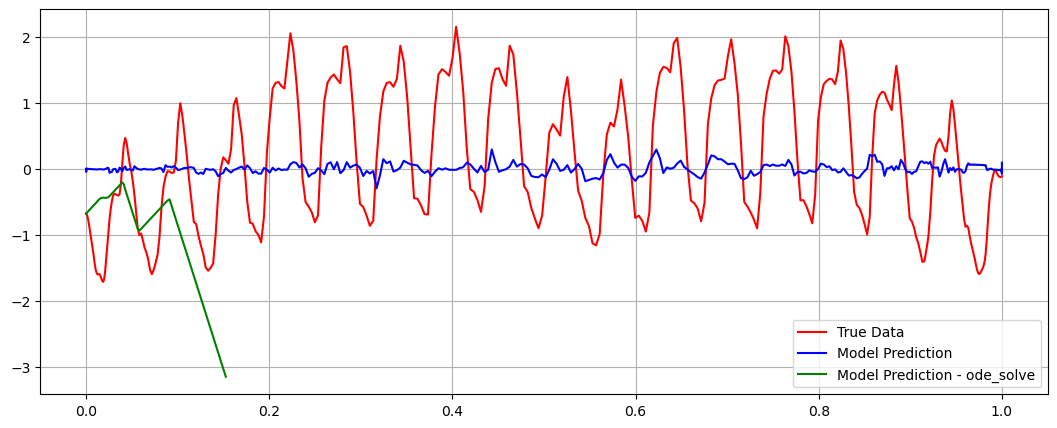

In [126]:
plt.figure(figsize=(13, 5))
plt.plot(t_train[offset : split], y_train_scaled[offset : split], 'r', label='True Data')
plt.plot(t_train[offset : split], u_model, 'b', label='Model Prediction')
plt.plot(t_train[offset : split][:100], ode_solution[:100], 'g', label='Model Prediction - ode_solve')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()